Classification Model: in-vehicle coupon recommendation Data Set

In [1]:
# If you'd like to install packages that are not installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere
# import sys
# !{sys.executable} -m pip install xgboost sklearn pandas numpy seaborn scipy matplotlib

In [58]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pd.set_option("display.max_columns", 101)

In [59]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Data Wrangling & Visualization

In [60]:
# Dataset is already loaded below
data = pd.read_csv("in-vehicle-coupon-recommendation.csv")
# data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00603/in-vehicle-coupon-recommendation.csv")
data.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0


Visualization

In [61]:
# plot definitions
def hist_plot(var):
    plt.hist(data[var],50,density=True,facecolor='g', alpha=0.75, histtype='bar', ec='black')
    plt.title('Histogram of '+var)
    plt.ylabel('Probability',fontsize=12)
    plt.xlabel(var,fontsize=12)
    current_values = plt.gca().get_xticks()
    plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
    plt.grid(True, color = "grey", linewidth = "0.2", linestyle = "-.")
    plt.savefig("img/hist_plot_"+var)
    plt.show()
    
def hist_plot_rot(var):
    plt.hist(data[var],50,density=True,facecolor='g', alpha=0.75, histtype='bar', ec='black')
    plt.title('Histogram of '+var)
    plt.ylabel('Probability',fontsize=12)
    plt.xlabel(var,fontsize=12)
    current_values = plt.gca().get_xticks()
    plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
    plt.grid(True, color = "grey", linewidth = "0.2", linestyle = "-.")
    plt.xticks(rotation=45)
    plt.savefig("img/hist_plot_rot_"+var)
    plt.show()
    
def hist_plot_perc(var):
    n, bin_edges = np.histogram(data[var], 100)
    # Normalize it, so that every bins value gives the probability of that bin
    bin_probability = n/float(n.sum())
    # Get the mid points of every bin
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
    # Compute the bin-width
    bin_width = bin_edges[1]-bin_edges[0]
    # Plot the histogram as a bar plot
    plt.bar(bin_middles, bin_probability, width=bin_width, ec='black')
    plt.title('Histogram of '+var)
    plt.ylabel('Probability',fontsize=12)
    plt.xlabel(var,fontsize=12)
    current_values = plt.gca().get_xticks()
    plt.gca().set_xticklabels(['{:,.2f}'.format(x) for x in current_values])
    plt.grid(True, color = "grey", linewidth = "0.2", linestyle = "-.")
    plt.savefig("img/hist_plot_perc_"+var)
    plt.show()
    
def freq_plot(var):
    if data[var].dtype==float:
        country_count = data[var].value_counts()
        country_count.index=country_count.index.astype(int)
    elif data[var].dtype!="O" and data[var].dtype=='int64':
        country_count = data[var].value_counts()
    else:
        country_count = data[var].fillna('Missing').value_counts(dropna=False)
    sns.set(style="darkgrid")
    sns.barplot(country_count.index[0:20],country_count.values[0:20],alpha=0.9)
    plt.title('Frequency Distribution of '+var)
    plt.ylabel('Number of Occurrences',fontsize=12)
    plt.xlabel(var,fontsize=12)
    plt.savefig("img/freq_plot_"+var)
    plt.show()
    
def freq_plot_rot(var):
    if data[var].dtype==float:
        country_count = data[var].value_counts()
        country_count.index=country_count.index.astype(int)
    else:
        country_count = data[var].fillna('Missing').value_counts(dropna=False)
    sns.set(style="darkgrid")
    sns.barplot(country_count.index[0:20],country_count.values[0:20],alpha=0.9)
    plt.title('Frequency Distribution of '+var)
    plt.ylabel('Number of Occurrences',fontsize=12)
    plt.xlabel(var,fontsize=12)
    plt.xticks(rotation=90)
    plt.savefig("img/freq_plot_rot_"+var)
    plt.show()
    
def crosstab(var,y):
    pd.crosstab(data[var],data[y]).plot(kind='bar')
    plt.title('Coupon Acceptance Frequency by '+var)
    plt.xlabel(var)
    plt.ylabel('Frequency of '+y)
    plt.savefig("img/crosstab_"+var)
    plt.show()

Variable Frequencies

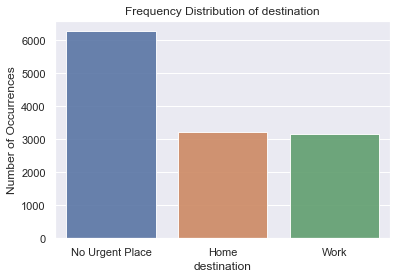

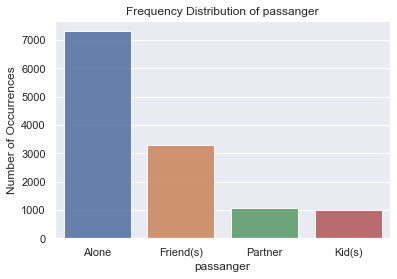

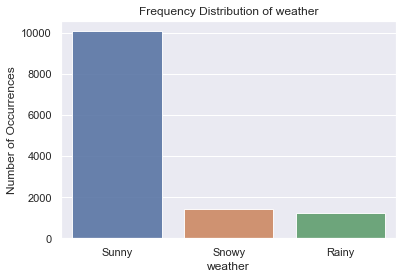

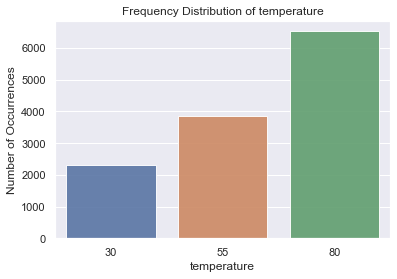

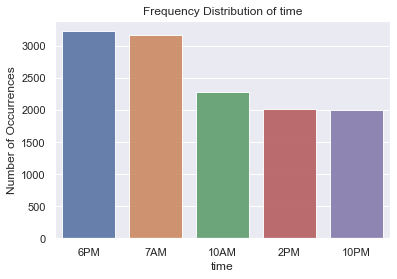

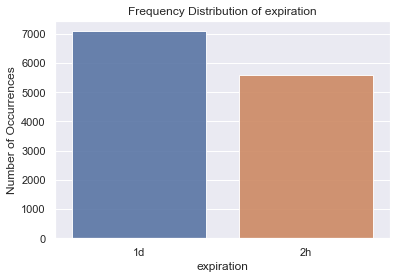

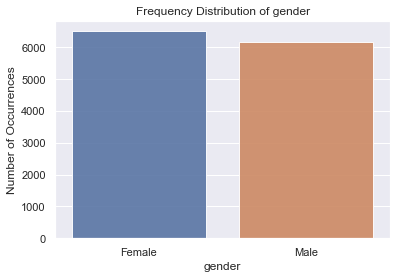

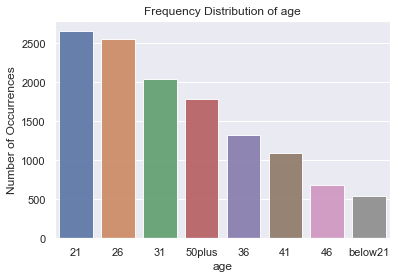

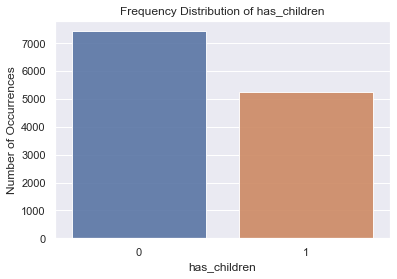

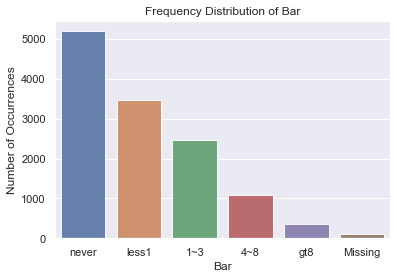

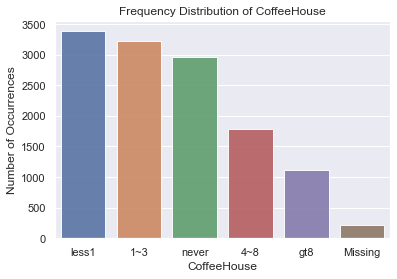

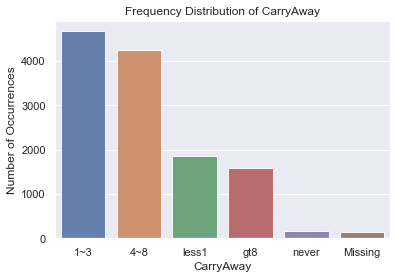

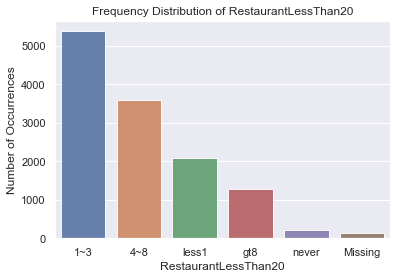

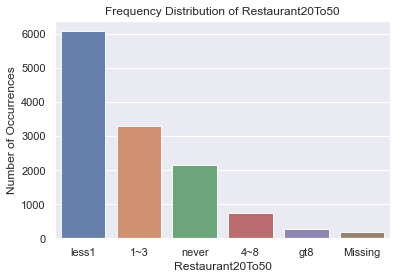

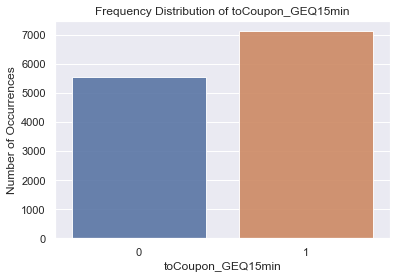

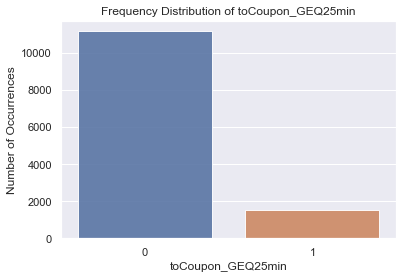

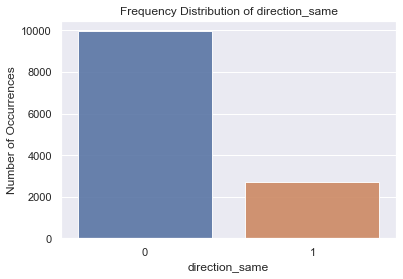

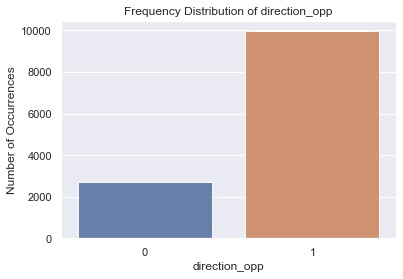

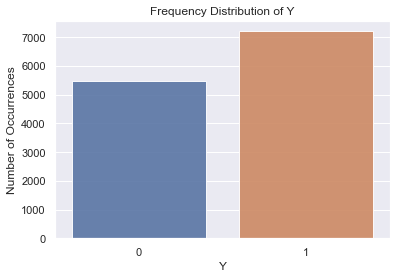

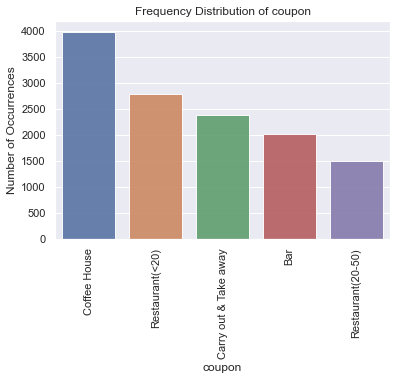

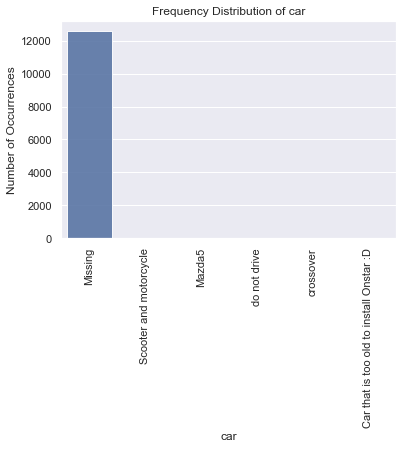

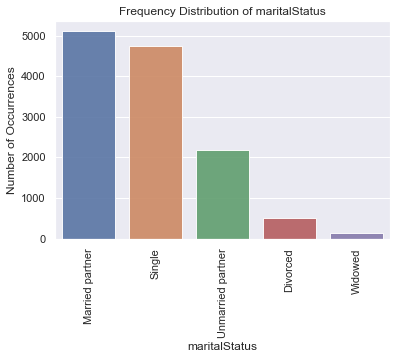

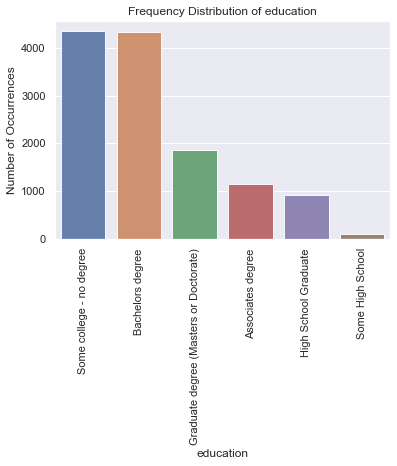

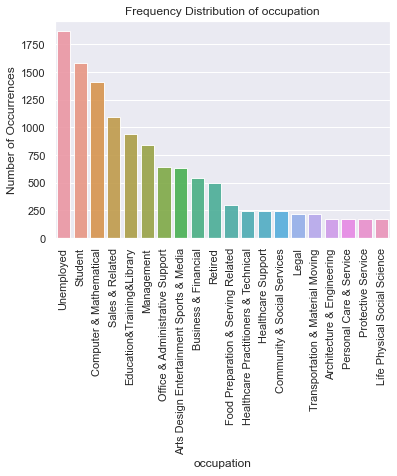

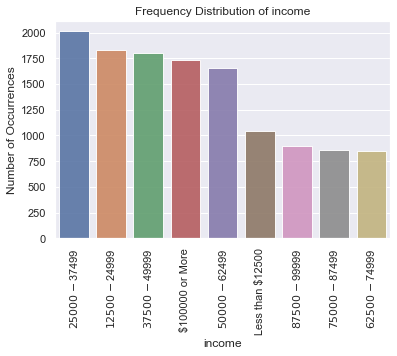

In [62]:
discrete=['destination',
          'passanger',
          'weather'
          ,'temperature'
          ,'time'
          ,'expiration'
          ,'gender'
          ,'age'
          ,'has_children'
          ,'Bar'
          ,'CoffeeHouse'
          ,'CarryAway'
          ,'RestaurantLessThan20'
          ,'Restaurant20To50'
          ,'toCoupon_GEQ15min'
          ,'toCoupon_GEQ25min'
          ,'direction_same'
          ,'direction_opp'
          ,'Y'
          ]
discrete_rot=['coupon',
              'car'
              ,'maritalStatus'
              ,'education'
              ,'occupation'
              ,'income'
          ]
for i in discrete:
    freq_plot(i)
for i in discrete_rot:
    freq_plot_rot(i)

We decide to drop "car" as it contains mostly missing values

In [63]:
data.drop(['car'],axis=1,inplace=True)
discrete_rot.remove('car')

Variable Relation with Outcome variable Y

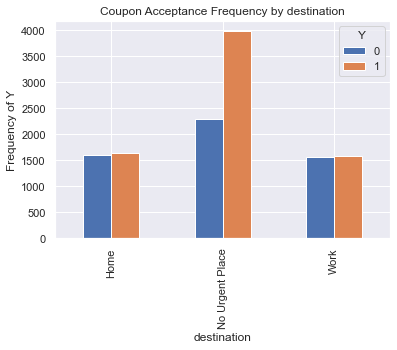

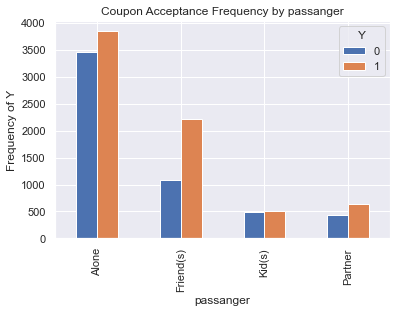

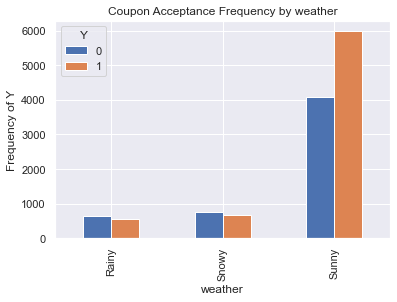

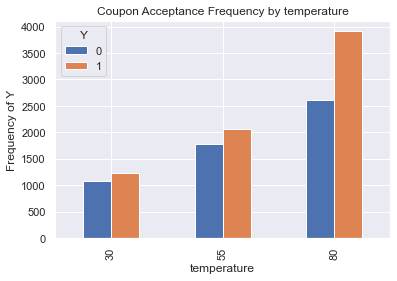

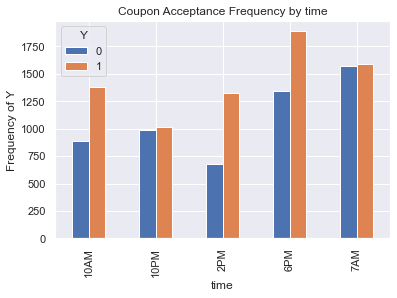

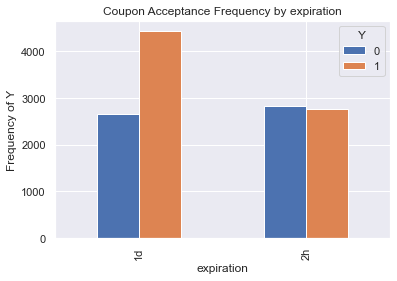

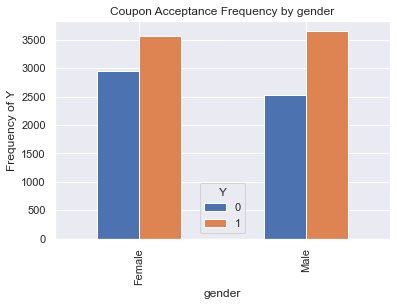

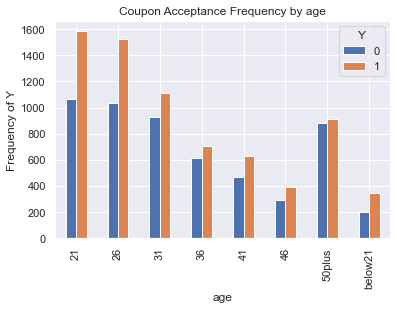

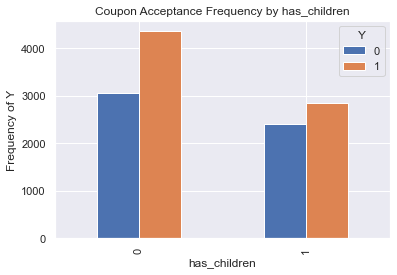

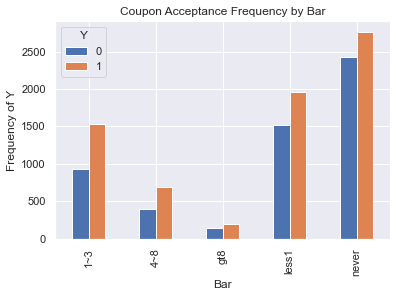

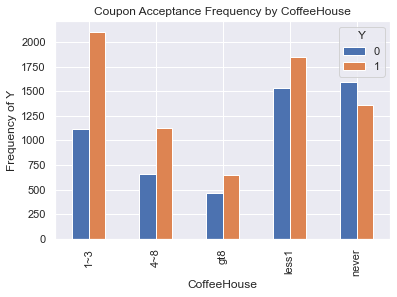

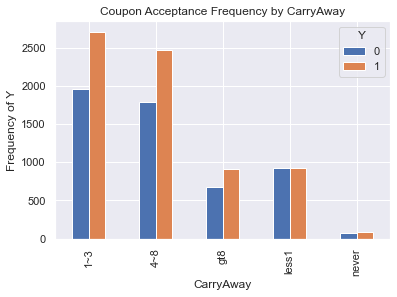

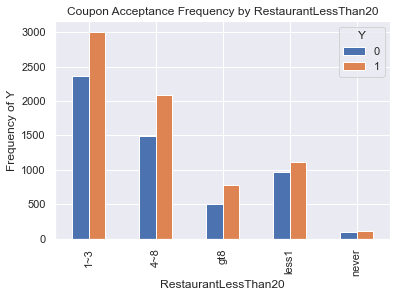

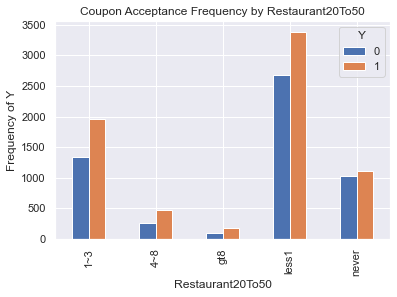

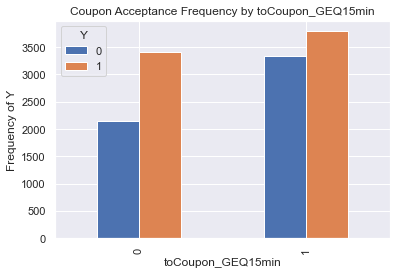

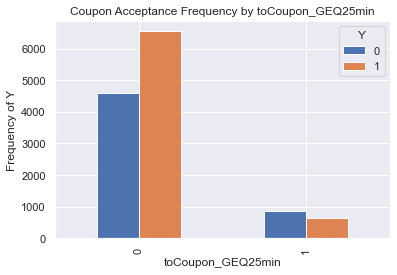

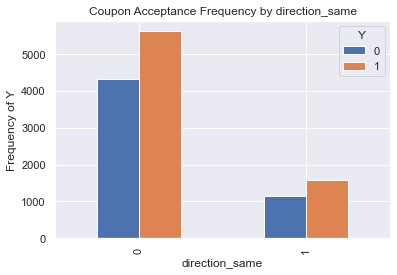

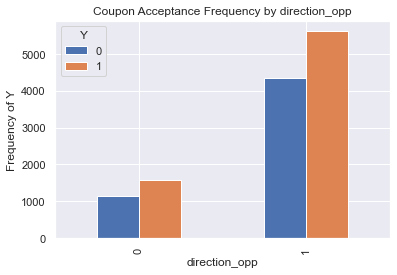

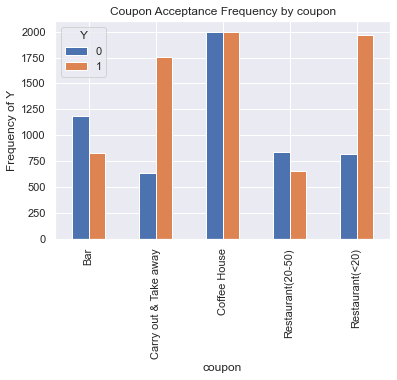

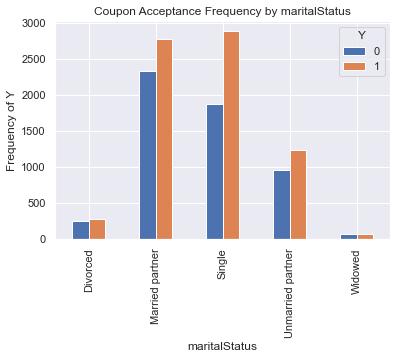

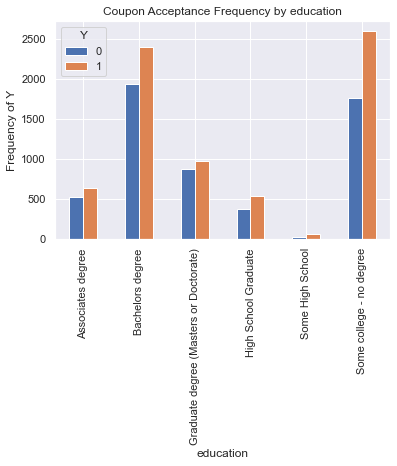

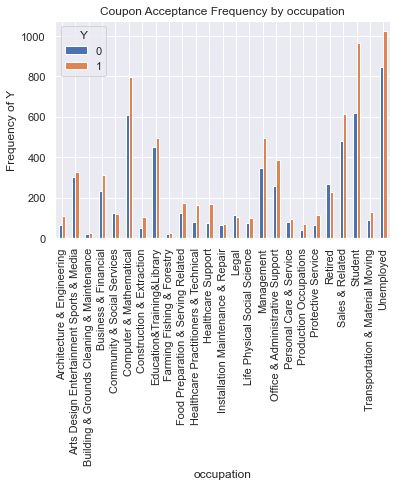

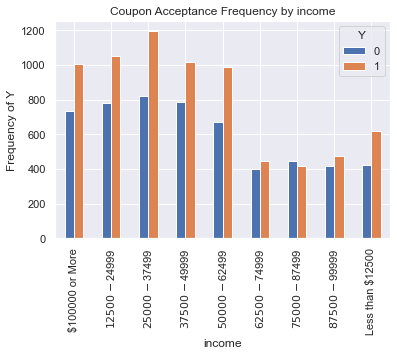

In [64]:
features=discrete+discrete_rot
features.remove('Y')
for i in features:
    crosstab(i,'Y')

We note that there are relatively more acceptances with:
* lower income
* lower age
* no children
* single
* Carry out & Take away
* Restaurant(<20)
* 1d expiration
* Sunny weather
* 80 temperature
* No urgent place

Let's create dummy variables for the features that have categories (which happen to be all our features in this dataset)

In [65]:
# dummies
for i in features:
    temp=pd.get_dummies(data[i],drop_first=True,dummy_na=False).reset_index(drop=True)
    temp=temp.add_prefix(i+'_')
    data.drop(i,axis=1,inplace=True)
    data=pd.concat([data,temp],axis=1)

In [66]:
# data adjustments
data.replace([np.inf,-np.inf], np.nan, inplace=True)
data=data.dropna().reset_index(drop = True)

Classification Model: Logistic Regression

In [67]:
# features and outcome variable
X=data.loc[:,data.columns!='Y']
y=data.Y

Let's firstly check for Multicollinearity issues within features

In [68]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data[vif_data['VIF']>8])

                               feature        VIF
2                     destination_Work        inf
13                            time_7AM        inf
46                    direction_same_1        inf
47                     direction_opp_1        inf
52       maritalStatus_Married partner   8.105416
53                maritalStatus_Single   8.615296
65  occupation_Computer & Mathematical   8.513236
82                  occupation_Student  10.099776
84               occupation_Unemployed  11.086409


Usually, a VIF above 8 is a sign of multicollinearity, so we shall drop recursively those variables with the highest VIF

In [69]:
# Multicollinearity adjustments
data=data.drop(['destination_Work'
                ,'direction_same_1'
                ,'toCoupon_GEQ5min'
        ],axis=1).reset_index(drop = True)

In [70]:
# VIF dataframe
X=data.loc[:,data.columns!='Y']
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data[vif_data['VIF']>1])

                                              feature       VIF
33                                    CarryAway_never  1.222004
37                         RestaurantLessThan20_never  1.255736
52                              maritalStatus_Widowed  1.454617
56                         education_Some High School  1.245521
59  occupation_Building & Grounds Cleaning & Maint...  1.241802
61             occupation_Community & Social Services  1.978077
63               occupation_Construction & Extraction  1.825592
65              occupation_Farming Fishing & Forestry  1.300429
67    occupation_Healthcare Practitioners & Technical  2.135233
68                      occupation_Healthcare Support  2.092198
69       occupation_Installation Maintenance & Repair  1.760777
70                                   occupation_Legal  1.911644
71            occupation_Life Physical Social Science  1.782693
74                 occupation_Personal Care & Service  1.830310
75                  occupation_Productio

Now we have removed multicollinear variables, we are ready for estimation/classification

In [71]:
# features and outcome variable
X=data.loc[:,data.columns!='Y']
y=data.Y


 Logistic Score : 0.692


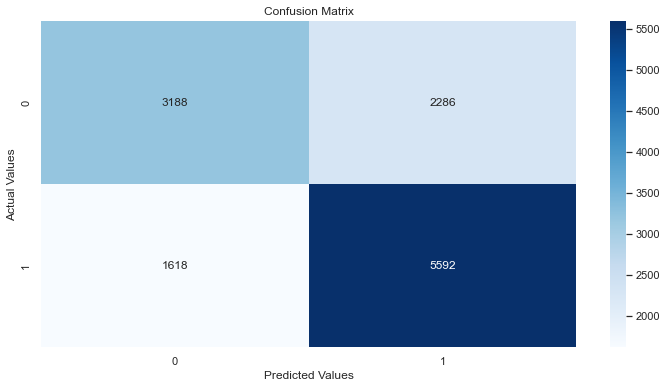

In [72]:
clf = LogisticRegression(random_state=0,fit_intercept=False).fit(X,y)

print("\n Logistic Score :",round(clf.score(X,y),3))

cm = confusion_matrix(y,clf.predict(X))
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.savefig("confusion_matrix_coupon.png")
plt.show()

Our estimated model predicts correctly 69.2% of the actual coupon decision (whether reject or accept)

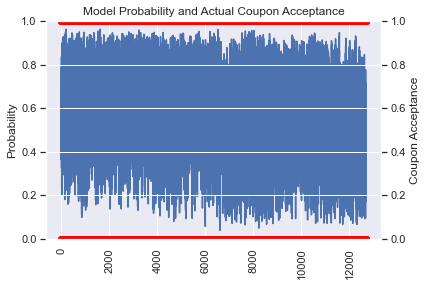

In [73]:
data['predict_probs']=clf.predict_proba(X)[:,1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(data.index,data['predict_probs'],label='Probability')
# plt.legend(loc='upper')
plt.ylabel("Probability")
plt.ylim([0,1])
plt.xticks(rotation=90)
axB = ax.twinx()
axB.scatter(data.index,y,color='red',label='Coupon Acceptance')
# plt.legend(loc='best')
plt.ylabel("Coupon Acceptance")
plt.ylim([0,1])
plt.xlabel("id")
plt.title("Model Probability and Actual Coupon Acceptance")
plt.savefig("probabilities_and_coupon.png")
plt.show()

Our estimated model leans towards predicting coupon acceptance with more frequency (prob > 0.5).

This is why it correctly predicts 5592 acceptances out of 7210 actual acceptances.

Nevertheless, our estimated model also predicts coupon rejects. 

It correctly predicts 3188 coupon rejects out of 5474 actual rejects.

AUC: 0.747


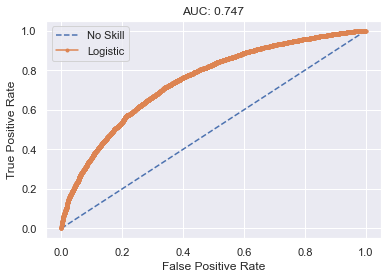

In [74]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(data['Y'],data['predict_probs'])
# calculate AUC
auc = roc_auc_score(data['Y'],data['predict_probs'])
print('AUC: %.3f' % auc)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(data['Y']))]
# calculate scores
ns_auc = roc_auc_score(data['Y'],ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(data['Y'],ns_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc='best')
plt.title(f"AUC: {round(auc,3)}")
# show the plot
plt.savefig("auc.png")
plt.show()

The Area Under the ROC curve (AUC) is an aggregated metric that evaluates how well a logistic regression model classifies positive and negative outcomes at all possible cutoffs. It can range from 0.5 to 1, and the larger it is the better.

Our estimated model has an AUC of 74.7%. 

A model with No Skill would have an AUC of 50%. 

A model with perfect predictive capability would have an AUC score of 100%.

Let us now consider the 10 most important factors in determining acceptance/rejection of coupons:

In [75]:
logreg = LogisticRegression(random_state=0,fit_intercept=False)
rfe = RFE(logreg,10)
rfe = rfe.fit(X,y.values.ravel())
# print(rfe.support_)
# print(rfe.ranking_)
# https://quantifyinghealth.com/interpret-logistic-regression-coefficients/
x=X.columns[rfe.ranking_==1]
print(x)
x=X[x]
logit_model=sm.Logit(y,x)
result=logit_model.fit(cov_type='HC3')
print(result.summary())

Index(['destination_No Urgent Place', 'passanger_Kid(s)', 'weather_Sunny',
       'expiration_2h', 'CoffeeHouse_never', 'direction_opp_1',
       'coupon_Carry out & Take away', 'coupon_Restaurant(<20)',
       'education_Some High School', 'occupation_Construction & Extraction'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.609579
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                12684
Model:                          Logit   Df Residuals:                    12674
Method:                           MLE   Df Model:                            9
Date:                Fri, 01 Apr 2022   Pseudo R-squ.:                  0.1085
Time:                        08:54:23   Log-Likelihood:                -7731.9
converged:                       True   LL-Null:                       -8672.7
Covariance Type:                  HC3   L

We notice that all ten coefficients are statistically significant. 

Their p-values are below 0.01, so our model suggests that these factors influence the acceptance/rejection of coupons, depending on the positive/negative sign respectively.

In particular, our model suggests that:
* destination_No Urgent Place
* weather_Sunny 
* coupon_Carry out & Take away
* coupon_Restaurant(<20)
* education_Some High School
* occupation_Construction & Extraction

do in fact increase the likelihood of accepting coupons.

On the contrary, our model suggests that:
* passanger_Kid(s)
* expiration_2h
* CoffeeHouse_never
* direction_opp_1 

do in fact decrease the likelihood of accepting coupons.

Let us interpret one of coefficients, as an example. Those coupons that have an expiration of 2hours have an estimated β = -0.7508, then e^β = 0.47. The interpretation becomes: coupons with a 2h expiration are associated with a 52% (1 – 0.47 = 0.52) reduction in the probability of being accepted.